# Workshop 2: Spatial & Geometry Operations on Vector data

Programación SIG  2025-1S    
Universidad Nacional de Colombia    
Alicia Arévalo Robinson

- Workshop extracted from [Link](https://github.com/lccastillov/prog_sig_2025_1/blob/main/Workshop6_SpatialOpertaions_Vector_Data.ipynb)  
- GitHub Repository: https://github.com/aliciaarevalor/PS

This project consists of carrying out two multicriteria analyses for the municipalities of the Orinoquia region. The criteria to consider are:

1. Number of IDEAM stations
2. Density of primary roads 
3. Population 
4. Proximity to primary roads
5. Simple drainage networks

The first analysis (Level 1) takes into account the first four criteria and, based on a weight assigned to each, obtains a weighted value for each municipality. From this level, the municipality with the highest value is selected and used for the next analysis. The second part of the study (Level 2) is a spatial analysis that identifies the best area to locate a new IDEAM station, considering criteria 1, 4, and 5.  

Data of primary roads were extracted from https://inviasopendata-invias.opendata.arcgis.com/, population from `municipios_colombia.shp`, IDEAM stations from `Catalogo_Estaciones_IDEAM.csv`, and simple drainage networks from https://www.datos.gov.co/en/dataset/Drenaje-Sencillo/68v7-gsra/about_data

## 0. Modules 🗒️

In [253]:
import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import contextily as cx
from pathlib import Path
from shapely.geometry import Point

import numpy as np
import shapely
from shapely import affinity

## 1. Input data 📂

#### Read files path

In [254]:
# Main folder
root_folder = "./data"

muni_path = root_folder + "/municipios_colombia.shp"

eva_path = root_folder + "/Evaluaciones_Agropecuarias_Municipales_EVA.csv"

ideam_path = root_folder + "/Catalogo_Estaciones_IDEAM.csv"

precip_path = root_folder + "/precipitacion.csv"

road_path = root_folder + "/RedVial.shp"

drainage_path = root_folder + "/Drenaje_Sencillo.geojson"

#### Read CSV files

In [255]:
eva = pd.read_csv(eva_path, encoding='utf-8')
ideam = pd.read_csv(ideam_path,encoding='utf-8')  
precip= pd.read_csv(precip_path, encoding='utf-8')

#### Read GeoDataFrames

In [256]:
# Read and project to EPSG:9377
muni = gpd.read_file(muni_path).to_crs(epsg=9377)
road = gpd.read_file(road_path).to_crs(epsg=9377)
drainage = gpd.read_file(drainage_path).to_crs(epsg=9377)

## 2. Data Preprocessing 🧹

### 2.1 `ideam`    

- Read location of IDEAM stations transforming coordinates to points. Then, read `ideam` as a GeoDataFrame  
- Spatial join `ideam` with `muni` to have geometry municipalities in ideam. This step is for plotting later.  


##### Read `ideam` as a GeoDataGrame

In [257]:
# Convert string coordinates to Points using string manipulation
ideam['geometry'] = ideam['Ubicación'].apply(
    lambda x: Point(
        float(x.strip('()').split(',')[1]),  # longitude
        float(x.strip('()').split(',')[0])   # latitude
    )
)

# Create GeoDataFrame
ideam_gdf = gpd.GeoDataFrame(
    ideam,
    geometry='geometry',
    crs="EPSG:4326"  
)

# Convert to EPSG:9377
ideam_gdf = ideam_gdf.to_crs(9377)

##### Spatial join each station to its municipality (`gpd.sjoin`)

Due that we will join `ideam_gdf` with `muni`, we need to have both GeoDataFrames with the same column for **Municipio**.  
For this, we rename the column **Municipio** to **MPIO_CNMBR** in `ideam_gdf`, and transform all strings to uppercase text. 

In [258]:
ideam_gdf = ideam_gdf.rename(columns={'Municipio': 'MPIO_CNMBR'})
ideam_gdf['MPIO_CNMBR'] = ideam_gdf['MPIO_CNMBR'].str.upper()

##### Join `ideam_gdf` with `muni` using `gpd.sjoin`

In [305]:
stations_with_muni = gpd.sjoin(
    ideam_gdf,   
    muni,         
    how='inner',
    predicate='within'  
)

`gpd.sjoin()` returns a GeoDataFrame with the geometry of the left DataFrame, so it is necessary to add a column with the geometry of municipalities.

In [306]:
# Add the municipality geometry as a new column
stations_with_muni['muni_geometry'] = stations_with_muni.apply(
    lambda row: muni.loc[row['index_right'], 'geometry'] if pd.notnull(row['index_right']) else None,
    axis=1
)

# Keep relevant columns
stations_with_muni = (stations_with_muni.rename(columns={"MPIO_CNMBR_left": "MPIO_CNMBR"}))
stations_with_muni=stations_with_muni[['Codigo','Nombre','Departamento','MPIO_CNMBR','MPIO_CDPMP','geometry','muni_geometry','DPTO_CCDGO']]
stations_with_muni.head()

,Codigo,Nombre,Departamento,MPIO_CNMBR,MPIO_CDPMP,geometry,muni_geometry,DPTO_CCDGO
0,52057100,RUMICHACA - AUT [52057100],Nariño,IPIALES,52356,POINT (4.48e+06 1.65e+06),"POLYGON ((4.49e+06 1.66e+06, 4.49e+06 1.66e+06...",52
1,52055170,LA JOSEFINA - AUT [52055170],Nariño,CONTADERO,52210,POINT (4.5e+06 1.66e+06),"POLYGON ((4.49e+06 1.66e+06, 4.49e+06 1.66e+06...",52
2,52055220,EL PARAISO - AUT [52055220],Nariño,TÚQUERRES,52838,POINT (4.48e+06 1.68e+06),"POLYGON ((4.49e+06 1.7e+06, 4.49e+06 1.7e+06, ...",52
3,44015070,EL PEPINO - AUT [44015070],Putumayo,MOCOA,86001,POINT (4.59e+06 1.68e+06),"POLYGON ((4.59e+06 1.72e+06, 4.59e+06 1.72e+06...",86
4,48015040,PUERTO NARINO - AUT [48015040],Amazonas,PUERTO NARIÑO,91540,POINT (5.29e+06 1.14e+06),"POLYGON ((5.29e+06 1.15e+06, 5.29e+06 1.15e+06...",91


### 2.2 Get departments and municipalities from Orinoquia region

##### From `muni`, get departments geometry dissolving the GeoDataFrame by **DPTO_CCDGO**

In [307]:
departments = muni.dissolve(by='DPTO_CCDGO', as_index=False)
departments=departments[['DPTO_CCDGO', 'geometry']]

##### Merge `departments` with `stations_with_muni` to get the name of each department by their code (**DPTO_CCDGO**)

In [308]:
departments_with_name = departments.merge(
    stations_with_muni,
    how='left',
    on='DPTO_CCDGO',
    validate='one_to_many',     
)

departments_with_name=departments_with_name[['DPTO_CCDGO','Departamento','geometry_x']].drop_duplicates(subset='DPTO_CCDGO')
departments_with_name=departments_with_name.set_geometry('geometry_x')

##### Select departments from Orinoquia Region

In [309]:
ori=departments_with_name[departments_with_name["Departamento"].isin(["Arauca", "Casanare", "Vichada", "Meta"])]

##### Extract municipalities from Orinoquia region

In [302]:
ori_muni = muni[muni["DPTO_CCDGO"].isin(ori["DPTO_CCDGO"])] 
ori_muni['area_km2'] = ori_muni.geometry.area / 1e6
ori_muni = ori_muni[['DPTO_CCDGO', 'MPIO_CNMBR','area_km2', 'geometry']]
print(ori_muni['MPIO_CNMBR'].tolist())

['SANTA ROSALÍA', 'PUERTO CARREÑO', 'LA PRIMAVERA', 'CUMARIBO', 'YOPAL', 'AGUAZUL', 'CHÁMEZA', 'LA SALINA', 'MANÍ', 'MONTERREY', 'NUNCHÍA', 'OROCUÉ', 'PORE', 'RECETOR', 'SABANALARGA', 'SÁCAMA', 'SAN LUIS DE PALENQUE', 'TÁMARA', 'TAURAMENA', 'TRINIDAD', 'VILLANUEVA', 'HATO COROZAL', 'PAZ DE ARIPORO', 'ARAUCA', 'PUERTO RONDÓN', 'CRAVO NORTE', 'ARAUQUITA', 'FORTUL', 'SARAVENA', 'TAME', 'VILLAVICENCIO', 'ACACÍAS', 'BARRANCA DE UPÍA', 'CABUYARO', 'CASTILLA LA NUEVA', 'CUBARRAL', 'CUMARAL', 'EL CALVARIO', 'EL CASTILLO', 'EL DORADO', 'FUENTE DE ORO', 'GRANADA', 'GUAMAL', 'MESETAS', 'URIBE', 'LEJANÍAS', 'PUERTO CONCORDIA', 'PUERTO LÓPEZ', 'PUERTO LLERAS', 'PUERTO RICO', 'RESTREPO', 'SAN CARLOS DE GUAROA', 'SAN JUAN DE ARAMA', 'SAN JUANITO', 'SAN MARTÍN', 'VISTAHERMOSA', 'LA MACARENA', 'MAPIRIPÁN', 'PUERTO GAITÁN']


c:\Users\VICTUS\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### 2.3 `muni`

Create a column of area of municipalities in km2

In [310]:
muni['area_km2'] = ori_muni.geometry.area / 1e6

##### Adjust `eva` and `muni` columns to be able to merge later

In [311]:
# EVA table, rename code column
eva = (eva.rename(columns={"CÓD. MUN.": "cod_mun"}))

eva["CULTIVO"] = eva["CULTIVO"].astype(str)      # ensure string

#Homogenise municipalities codes
muni["MPIO_CCDGO"] = muni["MPIO_CCDGO"].astype(str).str.zfill(5)
eva["cod_mun"]     = eva["cod_mun"].astype(str).str.zfill(5)

print(f"{len(muni):,} municipalities • {len(ideam):,} stations • "
      f"{len(eva):,} EVA rows")

1,122 municipalities • 8,973 stations • 206,068 EVA rows


##### Merge `muni` and `eva`

This merge is done to work with `eva` as a GeoDataFrame with the geometries of the municipalities

In [312]:
muni_eva = muni.merge(
    eva,
    how='left',                 
    left_on='MPIO_CDPMP',       
    right_on='cod_mun',            
    indicator=True,             
    validate='one_to_many',     
    suffixes=('', '_eva')       
)

### 2.4 Validate CRS of GeoDataFrames 

In [313]:
print("muni CRS:", muni.crs)       
print("ideam CRS:", ideam_gdf.crs)
print("road CRS:", road.crs)   
print("eva CRS:", muni_eva.crs)      
print("departments CRS:", departments_with_name.crs) 

muni CRS: EPSG:9377
ideam CRS: EPSG:9377
road CRS: EPSG:9377
eva CRS: EPSG:9377
departments CRS: EPSG:9377


## 3. Data analysis 📊

### **Level 1: Municipality selection**

The four criteria considered for this level are: Number of IDEAM stations per municipality, Primary roads density, Population density, and Proximity to primary roads.

#### **Number of IDEAM stations per municipalities**

Count number of stations in each municipality

In [303]:
station_counts = stations_with_muni.groupby('MPIO_CNMBR').size().reset_index(name='station_count')

Merge with `ori_muni`

In [270]:
ori_station_counts = ori_muni.merge(station_counts, on='MPIO_CNMBR', how='left')

# Fill municipalities with no stations with 0
ori_station_counts['station_count'] = ori_station_counts['station_count'].fillna(0).astype(int)

ori_station_counts = ori_station_counts[['DPTO_CCDGO','MPIO_CNMBR','station_count','area_km2','geometry']]

Stations density

In [304]:
ori_station_counts['stations_density']= ori_station_counts['station_count'] / ori_station_counts['area_km2']
ori_station_counts = ori_station_counts.sort_values(by="stations_density", ascending=False)
ori_station_counts.head()

,DPTO_CCDGO,MPIO_CNMBR,station_count,area_km2,geometry,stations_density
37,50,EL CALVARIO,12,277.439283,"POLYGON ((4.92e+06 2.05e+06, 4.92e+06 2.05e+06...",0.043253
30,50,VILLAVICENCIO,28,1283.784072,"POLYGON ((4.92e+06 2.03e+06, 4.92e+06 2.03e+06...",0.021811
6,85,CHÁMEZA,6,312.892884,"POLYGON ((5.02e+06 2.15e+06, 5.02e+06 2.15e+06...",0.019176
53,50,SAN JUANITO,3,236.990181,"POLYGON ((4.93e+06 2.06e+06, 4.93e+06 2.06e+06...",0.012659
34,50,CASTILLA LA NUEVA,6,513.862876,"POLYGON ((4.92e+06 1.99e+06, 4.92e+06 1.99e+06...",0.011676


#### **Primary roads density**

Calculate length of roads in km

In [272]:
road['length_m'] = road.geometry.length
road['length_km'] = road['length_m'] / 1000

Clip roads to each municipality

In [273]:
road_clip = gpd.overlay(road, ori_muni, how='intersection')

Sum road length by municipality

In [274]:
road_length_by_muni = road_clip.groupby('MPIO_CNMBR')['length_km'].sum().reset_index()
road_length_by_muni.rename(columns={'length_km': 'total_road_km'}, inplace=True)

Merge and compute road density

In [275]:
# Merge road lengths into municipality dataframe
road_muni = ori_muni.merge(road_length_by_muni, on='MPIO_CNMBR', how='right').copy()

# Calculate road density
road_muni['road_density'] = road_muni['total_road_km'] / road_muni['area_km2']
road_muni = road_muni.sort_values(by="road_density", ascending=False)
road_muni.head()

,DPTO_CCDGO,MPIO_CNMBR,area_km2,geometry,total_road_km,road_density
9,50,GRANADA,347.802390,"POLYGON ((4.92e+06 1.96e+06, 4.92e+06 1.96e+06...",294.116886,0.845644
13,85,LA SALINA,199.419246,"POLYGON ((5.07e+06 2.26e+06, 5.07e+06 2.26e+06...",122.961939,0.616600
30,85,SÁCAMA,311.467073,"POLYGON ((5.08e+06 2.24e+06, 5.08e+06 2.24e+06...",154.453490,0.495890
26,85,SABANALARGA,400.158205,"POLYGON ((5e+06 2.11e+06, 5e+06 2.11e+06, 5e+0...",143.259185,0.358006
25,50,RESTREPO,364.517064,"POLYGON ((4.94e+06 2.05e+06, 4.94e+06 2.05e+06...",108.611911,0.297961


#### **Population density**

Extract population data of each municipality from `muni`

In [276]:
ori_population = muni[muni["DPTO_CCDGO"].isin(ori["DPTO_CCDGO"])]
ori_population = ori_population[['DPTO_CCDGO', 'MPIO_CNMBR', 'MPIO_CDPMP', 'area_km2','STP27_PERS', 'geometry']]

Population density

Calculate population density diving population by area of municipality in km2

In [277]:
ori_population['pop_density'] = ori_population['STP27_PERS'] / ori_population['area_km2'] 
ori_population = ori_population.sort_values(by="pop_density", ascending=False)   
ori_population.head()

,DPTO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,area_km2,STP27_PERS,geometry,pop_density
909,50,VILLAVICENCIO,50001,1283.784072,451212.0,"POLYGON ((4.92e+06 2.03e+06, 4.92e+06 2.03e+06...",351.470321
920,50,GRANADA,50313,347.802390,64932.0,"POLYGON ((4.92e+06 1.96e+06, 4.92e+06 1.96e+06...",186.692219
910,50,ACACÍAS,50006,1122.077275,78199.0,"POLYGON ((4.91e+06 2.02e+06, 4.91e+06 2.02e+06...",69.691279
189,85,YOPAL,85001,2476.887302,156942.0,"POLYGON ((5.07e+06 2.17e+06, 5.07e+06 2.17e+06...",63.362592
635,81,SARAVENA,81736,942.587362,52884.0,"POLYGON ((5.14e+06 2.34e+06, 5.14e+06 2.34e+06...",56.105144


#### **Proximity to primary roads**

This step calculates the percentage of municipality area within 1 km of roads buffer

Create a buffer of 5 km

In [321]:
road_buffer=road_clip.copy()
road_buffer['geometry_5000'] = road_buffer.geometry.buffer(5000)
road_buffer = road_buffer[['length_km', 'geometry_5000']] # Select relevant columns
road_buffer=road_buffer.set_geometry("geometry_5000") # Set buffer created as a geometry column

Overlay `ori_muni` and `road_buffer` to get roads located in Orinoquia

In [322]:
buffer_muni = gpd.overlay(road_buffer, ori_muni, how='intersection')
buffer_muni.head()

,length_km,DPTO_CCDGO,MPIO_CNMBR,area_km2,geometry
0,53.153641,50,LA MACARENA,10825.971463,"POLYGON ((4.81e+06 1.82e+06, 4.81e+06 1.82e+06..."
1,14.341071,50,VILLAVICENCIO,1283.784072,"POLYGON ((4.93e+06 2.01e+06, 4.93e+06 2.01e+06..."
2,14.341071,50,ACACÍAS,1122.077275,"POLYGON ((4.92e+06 2.02e+06, 4.92e+06 2.02e+06..."
3,50.685022,85,MONTERREY,777.573425,"POLYGON ((5e+06 2.1e+06, 5e+06 2.1e+06, 5e+06 ..."
4,50.685022,85,SABANALARGA,400.158205,"POLYGON ((5e+06 2.09e+06, 5e+06 2.09e+06, 5e+0..."


% of municipality area within buffer

- Dissolve `buffer_muni` to get information of roads by munincipalities

In [323]:
buffer_muni_dissolved = buffer_muni.dissolve(by="MPIO_CNMBR")

- Calculate area in km2 of roads buffers

In [324]:
buffer_muni_dissolved['buffer_area_km2'] = buffer_muni_dissolved.geometry.area / 1e6

- Calculate percentage of municipality area inside roads buffers

In [328]:
buffer_muni_dissolved['area_in_buffer'] = (buffer_muni_dissolved['buffer_area_km2'] / buffer_muni_dissolved['area_km2']) * 100
buffer_muni_dissolved = buffer_muni_dissolved.sort_values(by="area_in_buffer", ascending=False)
buffer_muni_dissolved = buffer_muni_dissolved.reset_index()
buffer_muni_dissolved.head()

,MPIO_CNMBR,geometry,length_km,DPTO_CCDGO,area_km2,buffer_area_km2,area_in_buffer
0,GRANADA,"MULTIPOLYGON (((4.9e+06 1.94e+06, 4.9e+06 1.94...",69.988672,50,347.802390,278.622974,80.109563
1,VILLAVICENCIO,"POLYGON ((4.98e+06 2e+06, 4.98e+06 2e+06, 4.98...",14.341071,50,1283.784072,810.794997,63.156649
2,SABANALARGA,"POLYGON ((5e+06 2.07e+06, 5e+06 2.07e+06, 5e+0...",50.685022,85,400.158205,232.781839,58.172452
3,SÁCAMA,"POLYGON ((5.09e+06 2.23e+06, 5.09e+06 2.23e+06...",122.961939,85,311.467073,179.784677,57.721889
4,FUENTE DE ORO,"POLYGON ((4.95e+06 1.93e+06, 4.95e+06 1.93e+06...",103.594909,50,570.099585,314.623446,55.187454


Plot roads (with 5 km buffer) in Orinoquia

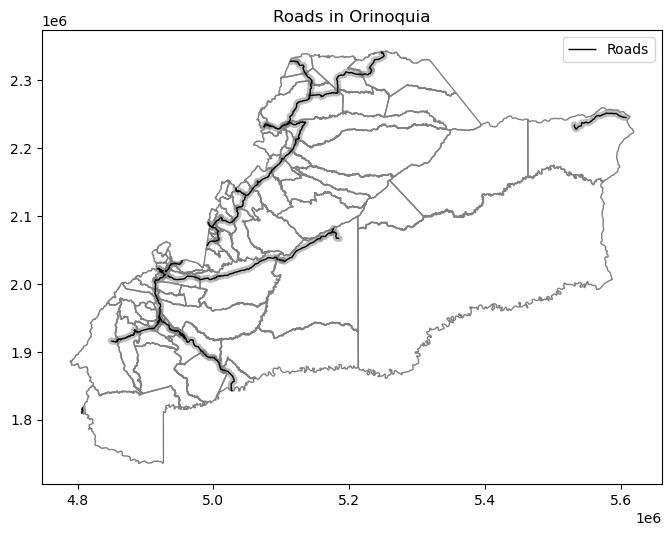

In [314]:
ax = ori_muni.plot(color="none", edgecolor="grey", figsize=(8, 8))

road_clip.plot(ax=ax, color="black", linewidth=1, label="Roads")
buffer_muni.plot(ax=ax, color="gray", alpha=0.5)

plt.legend()
plt.title("Roads in Orinoquia")
plt.show()

#### **Weighted criteria**

Define function to normalize values

In [326]:
def normalize(criteria):
    return (criteria - criteria.min()) / (criteria.max() - criteria.min())

Normalize criteria

In [335]:
ori_station_counts['norm_stations'] = normalize(ori_station_counts['stations_density'])
road_muni['norm_roaddensity'] = normalize(road_muni['road_density'])
ori_population['norm_popdensity'] = normalize(ori_population['pop_density'])
buffer_muni_dissolved['norm_proximity'] = normalize(buffer_muni_dissolved['area_in_buffer']) 

Merge columns with data of the criteria normalized. This step is useful to carry later a calculation of a pounded score.

In [338]:
ori_muni_final=ori_muni.merge(ori_station_counts[['MPIO_CNMBR','stations_density','norm_stations']], on='MPIO_CNMBR', how='left')
ori_muni_final = ori_muni_final.merge(road_muni[['MPIO_CNMBR','road_density','norm_roaddensity']], on='MPIO_CNMBR', how='left')
ori_muni_final = ori_muni_final.merge(ori_population[['MPIO_CNMBR','pop_density','norm_popdensity']], on='MPIO_CNMBR', how='left')
ori_muni_final = ori_muni_final.merge(buffer_muni_dissolved[['MPIO_CNMBR','area_in_buffer','norm_proximity']], on='MPIO_CNMBR', how='left')

Apply a score for each criteria

In [337]:
ori_muni_final['final_score']= (
    0.25 * ori_muni_final['norm_stations'] +
    0.25 * ori_muni_final['norm_roaddensity'] +
    0.25 * ori_muni_final['norm_popdensity'] +
    0.25 * ori_muni_final['norm_proximity'])

ori_muni_final= ori_muni_final.sort_values(by="final_score", ascending=False)
ori_muni_final.head(3)

,DPTO_CCDGO,MPIO_CNMBR,area_km2,geometry,stations_density,norm_stations,road_density,norm_roaddensity,pop_density,norm_popdensity,area_in_buffer,norm_proximity,final_score
30,50,VILLAVICENCIO,1283.784072,"POLYGON ((4.92e+06 2.03e+06, 4.92e+06 2.03e+06...",0.021811,0.504258,0.292006,0.339111,351.470321,1.000000,63.156649,0.788253,0.657906
41,50,GRANADA,347.802390,"POLYGON ((4.92e+06 1.96e+06, 4.92e+06 1.96e+06...",0.000000,0.000000,0.845644,1.000000,186.692219,0.530498,80.109563,1.000000,0.632625
15,85,SÁCAMA,311.467073,"POLYGON ((5.08e+06 2.24e+06, 5.08e+06 2.24e+06...",0.003211,0.074229,0.495890,0.582492,5.377776,0.013880,57.721889,0.720371,0.347743


Based on the table, the municipality that obtained a best score in the multi-criteria analysis is *Villavicencio (Meta)*.

### **Level 2: Best location within selected municipality**

The purpose of this analysis is to identify the best location to put a new IDEAM station in Villavicencio based on 3 criteria: Coverage of IDEAM stations (assuming a buffer of 5 km), Proximity to primary roads (prefering areas close to roads (2 km buffer)), and Proximity to drainage networks (not considering areas that are within a 1.5 km buffer).

#### Subset layers to selected municipality, which is *Villavicencio (Meta)*

In [287]:
villavo_muni = muni[muni["MPIO_CNMBR"].str.upper().str.contains("VILLAVICENCIO")].copy()

villavo_stations = stations_with_muni[stations_with_muni["MPIO_CNMBR"].str.upper().str.contains("VILLAVICENCIO")].copy()

villavo_roads = road_clip[road_clip["MPIO_CNMBR"].str.upper().str.contains("VILLAVICENCIO")].copy()

villavo_drainage = drainage

#### Plot IDEAM stations

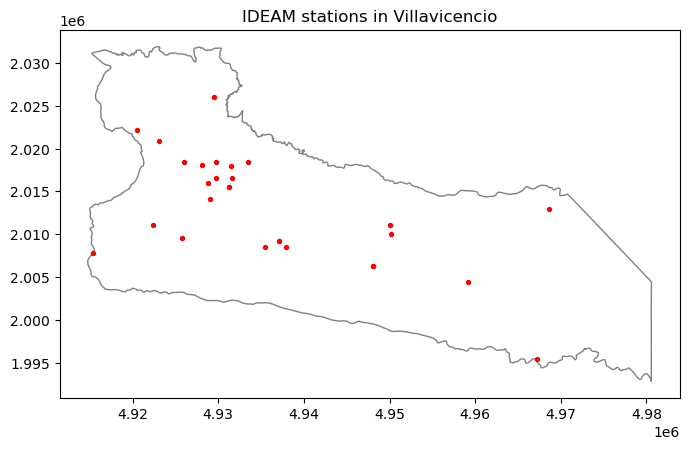

In [288]:
ax = villavo_muni.plot(color="none", edgecolor="grey", figsize=(8, 8))

villavo_stations.plot(ax=ax, color="red", markersize=8)
plt.title("IDEAM stations in Villavicencio")
plt.show()

#### **Coverage of IDEAM stations**

Create a buffer of 5 km

In [289]:
villavo_stations_buffer=villavo_stations.buffer(5000)

Dissolve buffers

In [290]:
villavo_stations_coverage = villavo_stations_buffer.union_all()
villavo_stations_coverage = gpd.GeoDataFrame(geometry=[villavo_stations_coverage], crs="EPSG:9377")
villavo_stations_coverage

,geometry
0,"MULTIPOLYGON (((4.97e+06 2e+06, 4.97e+06 1.99e..."


Plot

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_30216\3819861121.py:7: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


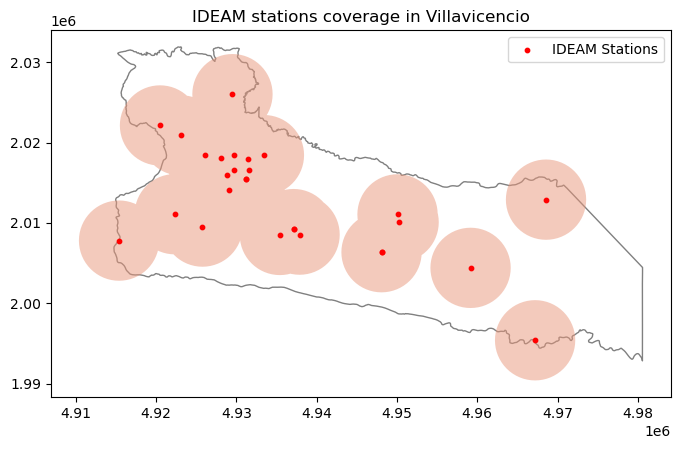

In [291]:
ax = villavo_muni.plot(color="none", edgecolor="grey", figsize=(8, 8))

villavo_stations_coverage.plot(ax=ax, color="darksalmon", alpha=0.5, label='Coverage Area')
villavo_stations.plot(ax=ax, color='red', markersize=10, label='IDEAM Stations')

plt.title("IDEAM stations coverage in Villavicencio")
plt.legend()
plt.show()

#### **Proximity to primary roads**

Create a buffer of 2 km

In [ ]:
villavo_roads_buffer = villavo_roads.buffer(2000)
villavo_roads_buffer = villavo_roads_buffer.union_all() 
villavo_roads_buffer = gpd.GeoDataFrame(geometry=[villavo_roads_buffer], crs="EPSG:9377")
villavo_roads_buffer

,geometry
0,"MULTIPOLYGON (((4.91e+06 2.01e+06, 4.91e+06 2...."


Plot

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_30216\3735468162.py:7: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


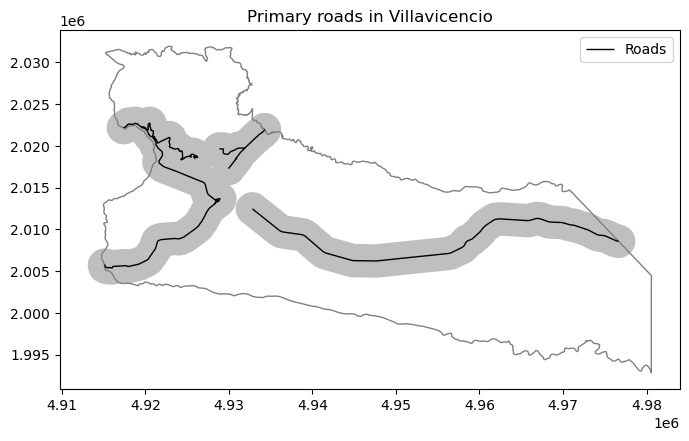

In [345]:
ax = villavo_muni.plot(color="none", edgecolor="grey", figsize=(8, 8))

villavo_roads_buffer.plot(ax=ax, color="gray", alpha=0.5, label="Road Buffer (1 km)")
villavo_roads.plot(ax=ax, color="black", linewidth=1, label="Roads")

plt.title("Primary roads in Villavicencio")
plt.legend()
plt.show()

#### **Proximity to simple drainage networks**

Create a buffer of 1.5 km

In [292]:
villavo_drainage_buffer=villavo_drainage.buffer(1500)

Dissolve buffers

In [293]:
villavo_drainage_buffer = villavo_drainage_buffer.union_all()
villavo_drainage_buffer = gpd.GeoDataFrame(geometry=[villavo_drainage_buffer], crs="EPSG:9377")
villavo_drainage_buffer

,geometry
0,"POLYGON ((4.95e+06 2e+06, 4.95e+06 2e+06, 4.95..."


Plot

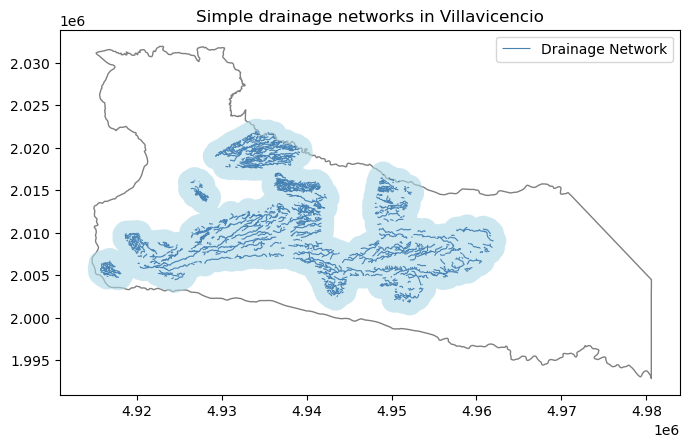

In [344]:
ax = villavo_muni.plot(color="none", edgecolor="grey", figsize=(8, 8))

villavo_drainage_buffer.plot(ax=ax, color="lightblue", alpha=0.6)
villavo_drainage.plot(ax=ax, color="steelblue", linewidth=0.8, label='Drainage Network')

plt.title("Simple drainage networks in Villavicencio")
plt.legend()
plt.show()

#### **Find candidate area**

The best area to put a new IDEAM station needs to be close to a primary road, to be in an area not covered by other stations, and to not be over or too close to a drainage network. To get this, we need to intersect the buffer of the roads with the underserved areas by IDEAM. Then, we need to difference the past intersection with the buffer of the drainage networks. 

##### 1. Find areas not covered by IDEAM stations (difference with municipality)

For this practice, it is assumed that the area outside the 5 km buffers of IDEAM stations are not covered by the meteorological institution.

Difference of `villavo_muni` with `villavo_stations_coverage`

In [297]:
underserved = villavo_muni.geometry.difference(villavo_stations_coverage, align=False)

Plot

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_30216\3924446469.py:8: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


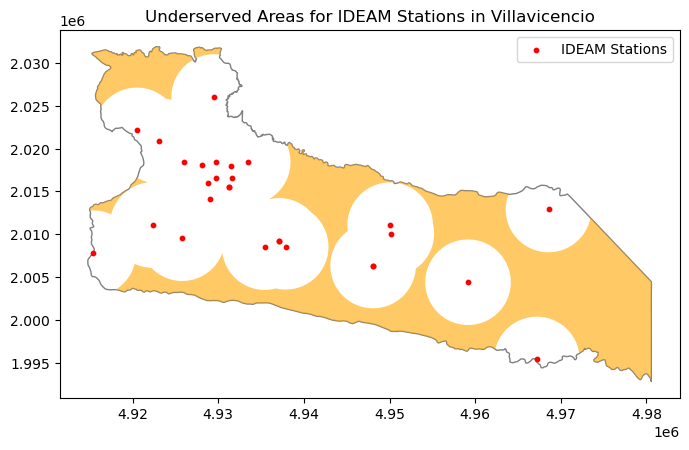

In [343]:
ax = villavo_muni.plot(color="none", edgecolor="grey", figsize=(8, 8))

underserved.plot(ax=ax, color="orange", alpha=0.6, label="Underserved Area")
#villavo_roads.plot(ax=ax, color="black", linewidth=0.8, label='Road')
villavo_stations.plot(ax=ax, color='red', markersize=10, label='IDEAM Stations')

plt.title("Underserved Areas for IDEAM Stations in Villavicencio")
plt.legend()
plt.show()

##### 2. Intersection of `villavo_roads_buffer` with `underserved`

In [299]:
intersection = underserved.intersection(villavo_roads_buffer.unary_union)

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_30216\894075335.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  intersection = underserved.intersection(villavo_roads_buffer.unary_union)


##### 3. Difference of `villavo_drainage_buffer` with `intersection`

In [300]:
candidate_area = intersection.geometry.difference(villavo_drainage_buffer, align=False)

##### 4. Candidate area 

Plot

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_30216\407651587.py:6: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
C:\Users\VICTUS\AppData\Local\Temp\ipykernel_30216\407651587.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


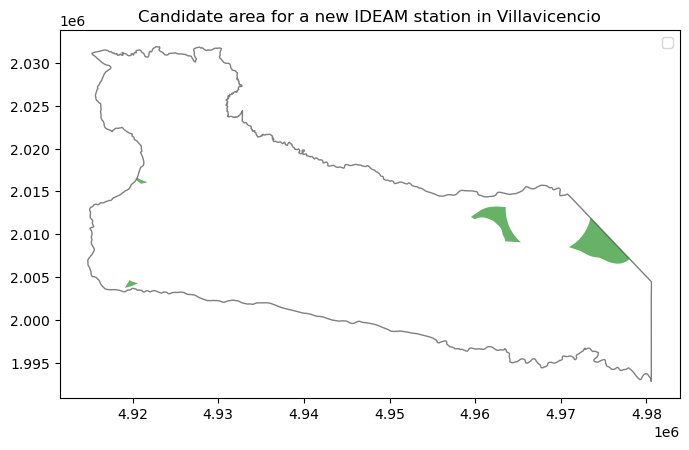

In [348]:
ax = villavo_muni.plot(color="none", edgecolor="grey", figsize=(8, 8))

candidate_area.plot(ax=ax, color="green", alpha=0.6, label="Underserved Area")

plt.title("Candidate area for a new IDEAM station in Villavicencio")
plt.legend()
plt.show()

The green zone represents candidate areas where is a good option to put a new IDEAM station in Villavicencio, based on the selected criteria.